#**Abstract** 
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter. 
But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this project, we choose the Kaggle competition, NLP with Disaster Tweets as our topics. We aim to use NLP model to predict the disaster tweet. 

# **Data set**

There are four Columns in our data set: id, text, location, keyword, target.  we are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# **Table of content**
####**1.	Notebook Configuration**

    a.	Import Package 

    b.	Google-Drive
####**2.	Exploratory data analysis**

    a.	Class Distribution 

    b.	Number of Characters in Tweets 

    c.	Number of Words in Tweets 

    d.	Average Word Length in a Tweet 

    e.	Common Stopwords in Tweets 

    f.	Punctuation 

    g.	Common words 
####**3.	Data Preprocessing**
    a.	Remove URL and Non-ASCLL Characters

    b.	Remove Emoji 

    c.	Remove punctuations 

    d.	Clean Abbreviations 

    e.	Word Cloud 
####**4.	Model**

    a.	GloVe for Vectorization 

    b.	Baseline Model  

    c.	Learning Curve

    d.    Submission


####**5.	Conclusion**


#Importing required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('ngrams')

from wordcloud import WordCloud

import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

import torch

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading ngrams: Package 'ngrams' not found in index


In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/6202/final/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the data and getting basic idea

In [ ]:
tweet= pd.read_csv(abspath_curr+'train.csv')
test=pd.read_csv(abspath_curr+'test.csv')
submission=pd.read_csv(abspath_curr+'sample_submission.csv')
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


#Class distribution
Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.

Text(0, 0.5, 'samples')

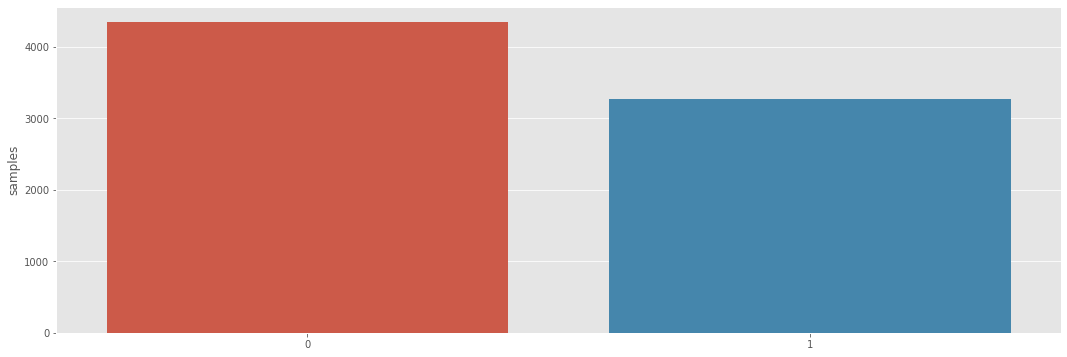

In [ ]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

Class distribution result : There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

##Number of characters in tweets

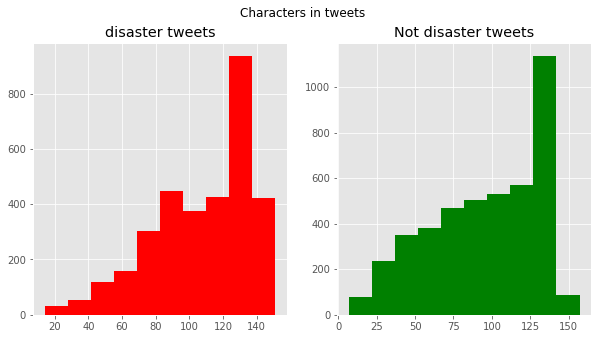

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

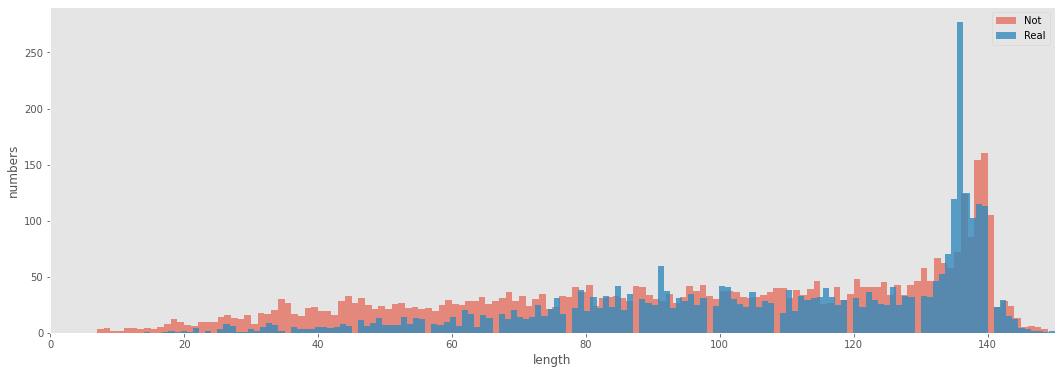

In [ ]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

tweet['length'] = tweet['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

The distribution of both seems to be almost the same. 120 to 140 characters is the range that most tweet belongs to.

##Number of words in a tweet

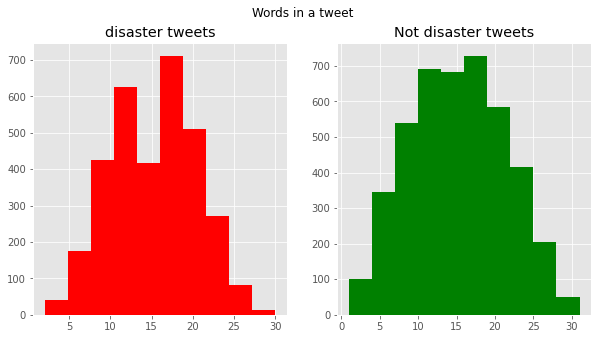

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

##Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

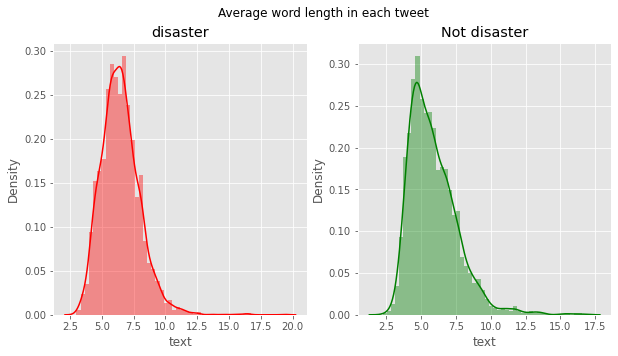

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

functions that will be used later for checking common words

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

##Common stopwords in tweets

Stop words are words which are filtered out before processing text.

First we will analyze tweets with class 0.

In [ ]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

#generate a word list of common stopwords
np.array(stop)



array({'of', "isn't", 'you', 'they', 'your', 'd', "wasn't", 'be', 'theirs', "mightn't", 'll', 'who', 're', 'own', 'themselves', 'too', 'the', 'most', 'very', 'its', 'down', 'but', 'myself', 'don', 'shan', 'so', 'while', "shan't", 'other', 'will', 'me', 'been', 's', 'his', 'because', 'once', 'by', 'or', 'y', 'doing', 'yourselves', 'ourselves', 'there', 'more', 'with', 'we', 'isn', 'itself', 'and', "don't", "that'll", 'i', 'an', 'am', 'here', "hadn't", 'she', 'hers', 'have', "aren't", 'those', 'off', 'to', 'our', 'wouldn', 'about', 'only', 'where', 'how', 'does', "won't", 'are', 'these', 'a', 'which', 'my', 'him', 'over', 'has', "haven't", 'whom', 'between', 'for', 'any', 'haven', 'do', 'up', 'why', 'ma', "she's", 'their', 'ours', "wouldn't", 'again', 'nor', 'what', 'each', 'that', 'out', 'further', 'them', 'her', 'such', 'won', 'aren', 'o', 'now', "mustn't", 'during', 'against', "didn't", 'was', "you'll", 'no', 'through', 'not', "should've", "it's", 'when', 'some', 'at', 'same', 'should

<BarContainer object of 10 artists>

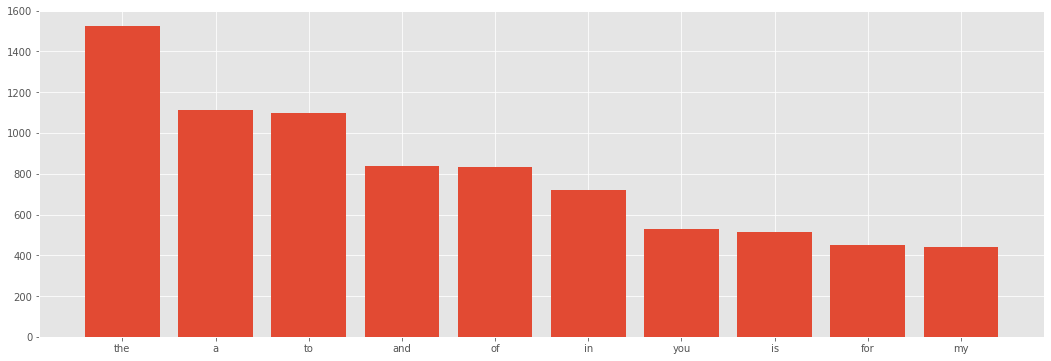

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

Top three most common stopwords for not real diaster tweets are: 'the', 'a', 'to'

analyze tweets with class 1

In [ ]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
np.array(stop)
#same as in class 0

array({'of', "isn't", 'you', 'they', 'your', 'd', "wasn't", 'be', 'theirs', "mightn't", 'll', 'who', 're', 'own', 'themselves', 'too', 'the', 'most', 'very', 'its', 'down', 'but', 'myself', 'don', 'shan', 'so', 'while', "shan't", 'other', 'will', 'me', 'been', 's', 'his', 'because', 'once', 'by', 'or', 'y', 'doing', 'yourselves', 'ourselves', 'there', 'more', 'with', 'we', 'isn', 'itself', 'and', "don't", "that'll", 'i', 'an', 'am', 'here', "hadn't", 'she', 'hers', 'have', "aren't", 'those', 'off', 'to', 'our', 'wouldn', 'about', 'only', 'where', 'how', 'does', "won't", 'are', 'these', 'a', 'which', 'my', 'him', 'over', 'has', "haven't", 'whom', 'between', 'for', 'any', 'haven', 'do', 'up', 'why', 'ma', "she's", 'their', 'ours', "wouldn't", 'again', 'nor', 'what', 'each', 'that', 'out', 'further', 'them', 'her', 'such', 'won', 'aren', 'o', 'now', "mustn't", 'during', 'against', "didn't", 'was', "you'll", 'no', 'through', 'not', "should've", "it's", 'when', 'some', 'at', 'same', 'should

<BarContainer object of 10 artists>

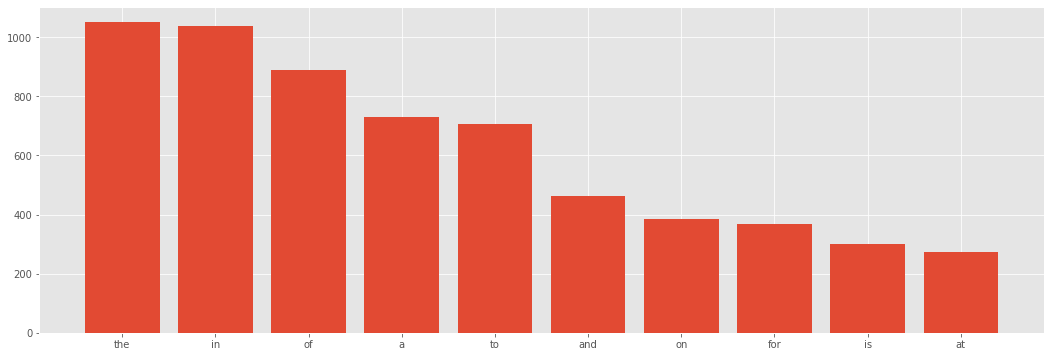

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

Top three most common stopwords for  real diaster tweets are: 'the', 'in', 'of'

To sum up, in both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

##Analyzing punctuations.
First check tweets indicating real disaster. class=1

<BarContainer object of 18 artists>

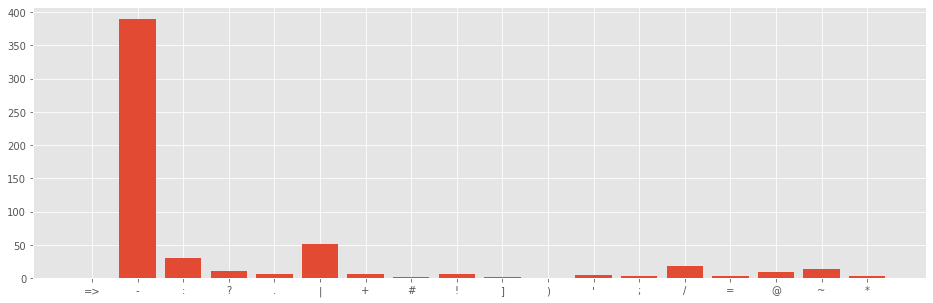

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

not real diaster. class 0

<BarContainer object of 20 artists>

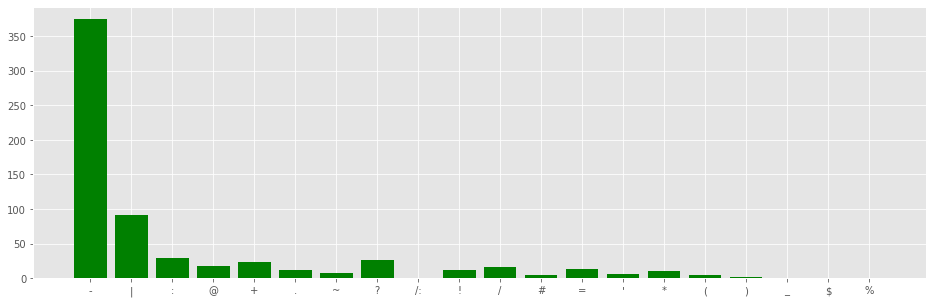

In [ ]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

##Common words

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

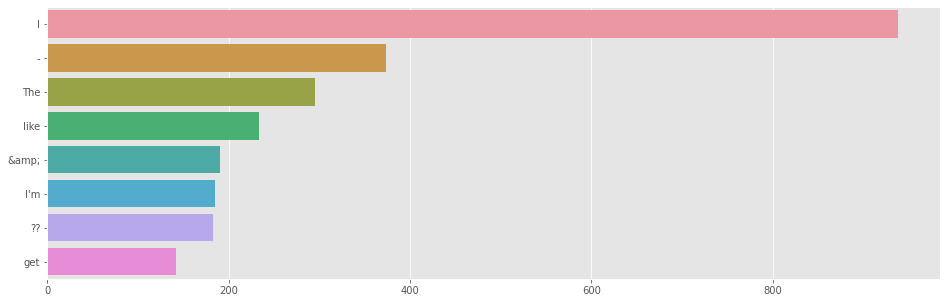

In [ ]:
#generate a bar chart that indicates most common words showing in a tweet.
plt.figure(figsize=(16,5))
sns.barplot(x=y,y=x)

Later we will genearte word cloud to show some of the common words for both class.

#Data Cleaning
clean the dataset before modeling, methods like removing punctions and removing html tags.

In [ ]:
df=pd.concat([tweet,test])
df.shape

(10876, 6)

###Removing urls

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

###Removing HTML tags

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Romoving Emojis

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### Removing punctuations

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

# clean abbreviation 

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word


def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [ ]:
df['text']=df['text'].apply(lambda x: convert_abbrev_in_text(x))

# word cloud 
generate word clouds for both class to make the common words more straightforward.

class 1

In [ ]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)

46581

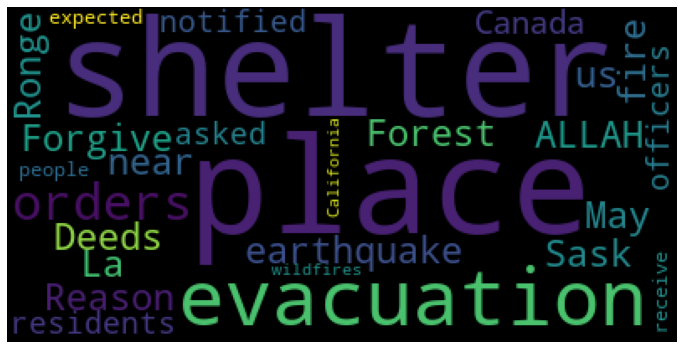

In [ ]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

class 0

In [ ]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

60959

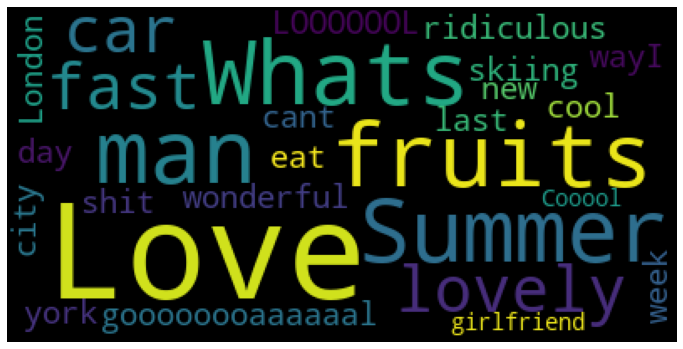

In [ ]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
df.head(10)

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88.0
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in b...,1.0,110.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1.0,95.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1.0,59.0
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1.0,79.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1.0,52.0


## GloVe for Vectorization
Here we will use GloVe.twitter pretrained corpus model to represent our words.

"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."


In [ ]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [ ]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7912.95it/s]


In [ ]:
#https://nlp.stanford.edu/projects/glove/

embedding_dict={}
with open(abspath_curr+'glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20276


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20276/20276 [00:00<00:00, 454740.28it/s]


# Baseline Model

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2027700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,108,201
Trainable params: 80,501
Non-trainable params: 2,027,700
_________________________________________________________________


In [ ]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 280s - loss: 0.5131 - accuracy: 0.7670 - val_loss: 0.4506 - val_accuracy: 0.8030
Epoch 2/15
1618/1618 - 279s - loss: 0.4755 - accuracy: 0.7881 - val_loss: 0.4460 - val_accuracy: 0.8039
Epoch 3/15
1618/1618 - 276s - loss: 0.4671 - accuracy: 0.7850 - val_loss: 0.4483 - val_accuracy: 0.8126
Epoch 4/15
1618/1618 - 275s - loss: 0.4597 - accuracy: 0.7968 - val_loss: 0.4496 - val_accuracy: 0.8065
Epoch 5/15
1618/1618 - 268s - loss: 0.4515 - accuracy: 0.7982 - val_loss: 0.4364 - val_accuracy: 0.8135
Epoch 6/15
1618/1618 - 266s - loss: 0.4414 - accuracy: 0.8045 - val_loss: 0.4671 - val_accuracy: 0.8047
Epoch 7/15
1618/1618 - 261s - loss: 0.4462 - accuracy: 0.8054 - val_loss: 0.4431 - val_accuracy: 0.8126
Epoch 8/15
1618/1618 - 260s - loss: 0.4299 - accuracy: 0.8144 - val_loss: 0.4290 - val_accuracy: 0.8205
Epoch 9/15
1618/1618 - 263s - loss: 0.4318 - accuracy: 0.8129 - val_loss: 0.4301 - val_accuracy: 0.8152
Epoch 10/15
1618/1618 - 262s - loss: 0.4247 - accuracy: 0.8187 -

In [ ]:
directory = os.path.dirname(abspath_curr + '/result/')
if not os.path.exists(directory):    
  os.makedirs(directory)

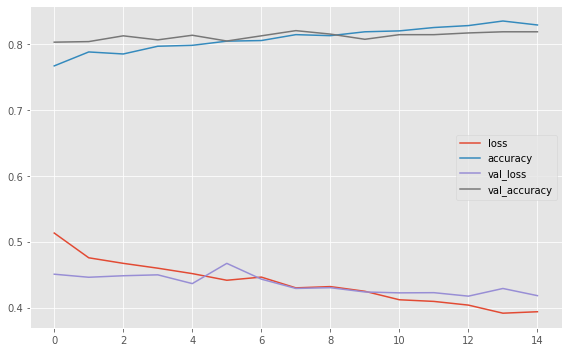

In [ ]:
# Create a figurepd.
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/learning_curve.pdf')
plt.show()

## Making our submission

In [ ]:
sample_sub=pd.read_csv(abspath_curr+'sample_submission.csv')

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv(abspath_curr+'submission.csv',index=False)

In [ ]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# Conclusion

To sum up, GloVe model has a relatively high accuracy and can be helpful for diaster prediction based on twitter. There are also many other models for NLP available which can be helpful for this certain task. During the whole process, we made many analysis on EDA part which can be very useful for reader, to give them a more straightforward concept on the dataset, therefore making further analysis. In addition, when dealing with text format data. Data cleaning is very important and necessary, for it can save time and make the raw data readable.
